# Tutorial for multiclass classification on continuous variables using _ImaGene_

In this example, the aim is to estimate a continuous parameter.
Please refer to the tutorial for binary and multiclass classification for an in-depth explanation of each step and case study.
Briefly, we aim at estimating the selection coefficient on one variant conferring lactase persistence in Europeans.
We will discretize the distribution into classes and perform a multiclass classification.

In [2]:
import os
import gzip
import _pickle as pickle

import numpy as np
import scipy.stats
import pymc3

import skimage.transform
from keras import models, layers, activations, optimizers, regularizers
from keras.utils import plot_model
from keras.models import load_model

import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pydot # optional, but required by keras to plot the model

Using TensorFlow backend.


In [3]:
%run -i ../ImaGene.py

### 1. read data from VCF file and store it into _ImaGene_ objects

In [12]:
file_LCT = ImaFile(nr_samples=198, VCF_file_name='LCT.CEU.vcf')
gene_LCT = file_LCT.read_VCF()

As an illustration, here we will sort rows by distance and columns by frequency and resize the image to (128,128).

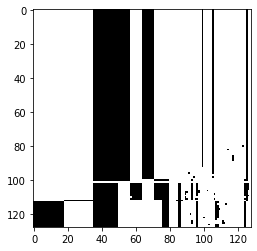

An object of 1 image(s)
Rows: min 128, max 128, mean 128.000000, std 0.000000
Columns: min 128, max 128, mean 128.000000, std 0.000000


0

In [13]:
gene_LCT.filter_freq(0.005)
gene_LCT.sort('rows_dist')
gene_LCT.sort('cols_freq')
gene_LCT.resize((128,128))
gene_LCT.convert(flip=True)
gene_LCT.plot()
gene_LCT.summary()

### 2. run and process simulations to be used for training the neural network

We provide an example of parameter file called `params_continuous` which simulates a total of 205,000 loci of 80kbp with allelic selection coefficients from 0 to 400 in $2N_e$ units with $N_e=10,000$ with a step of 1 and additive effect.
All other parameters are set as in the example of binary classification.

In [8]:
import subprocess
subprocess.call("bash ../generate_dataset.sh params_continuous.txt".split())

0

We wish to perform a multiclass classification to estimate the selection coefficient, a continuous parameter. 
In _ImaGene_ we can easily do that by imposing a new discrete set of classes and reassign the new targets to such classes with the methods `.set_classes` and `.set_targets`.

In [ ]:
?gene_sim.set_classes

In [ ]:
?gene_sim.set_targets

### 3. implement, train and evaluate the neural network

The pipeline for training and testing is the following one.

In [15]:
i = 1
while i <= 10:

    # simulations 
    file_sim = ImaFile(simulations_folder='/home/mfumagal/Downloads/ImaGene/Continuous/Simulations' + str(i), nr_samples=198, model_name='Marth-3epoch-CEU')

    # retain only 20 data points per class as a quick example
    gene_sim = file_sim.read_simulations(parameter_name='selection_coeff_hetero', max_nrepl=20)
    
    # manipulate data
    gene_sim.filter_freq(0.005)
    gene_sim.sort('rows_dist')
    gene_sim.sort('cols_freq')
    gene_sim.resize((128,128))
    gene_sim.convert(flip=True)
    
    # we assign 11 classes out of all the data simulated
    gene_sim.set_classes(nr_classes=11)
    if i == 1:
        print(gene_sim.classes)
    # and we assign targets corresponding to the previously set classes 
    gene_sim.set_targets()
    
    # randomise data
    gene_sim.subset(get_index_random(gene_sim))

    # targets have to be converted into categorical data; 
    # here we can use some extra options to, for instance, impose a Guassian distribution on the true targets
    gene_sim.targets = to_categorical(gene_sim.targets, wiggle=0, sd=0.5)
    
    # at first iteration we build the model 
    # note that, as an illustration, we don't implement a final fully-connected layer as we are double sorting the matrix
    if i == 1:

        model = models.Sequential([
                    layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.005, l2=0.005), padding='valid', input_shape=gene_sim.data.shape[1:]),
                    layers.MaxPooling2D(pool_size=(2,2)),
                    layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.005, l2=0.005), padding='valid'),
                    layers.MaxPooling2D(pool_size=(2,2)),
                    layers.Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.005, l2=0.005), padding='valid'),
                    layers.MaxPooling2D(pool_size=(2,2)),
                    layers.Flatten(),
                    layers.Dense(units=len(gene_sim.classes), activation='softmax')])
        model.compile(optimizer='adam',
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

        net_LCT = ImaNet(name='[C32+P]+[C64+P]+[C128+P]')

    # training for iterations from 1 to 9
    print(i)
    if i < 10:
        score = model.fit(gene_sim.data, gene_sim.targets, batch_size=32, epochs=1, verbose=1, validation_split=0.10)
        net_LCT.update_scores(score)
    else:
        # testing for iteration 10
        net_LCT.test = model.evaluate(gene_sim.data, gene_sim.targets, batch_size=None, verbose=1)
        net_LCT.predict(gene_sim, model)

    i += 1

[  0  40  80 120 160 200 240 280 320 360 400]






1
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 7218 samples, validate on 802 samples
Epoch 1/1





7218/7218 [==============================] - 63s 9ms/step - loss: 4.2222 - acc: 0.1664 - val_loss: 2.2298 - val_acc: 0.2020
2
Train on 7218 samples, validate on 802 samples
Epoch 1/1
7218/7218 [==============================] - 62s 9ms/step - loss: 2.1969 - acc: 0.2303 - val_loss: 2.1038 - val_acc: 0.2182
3
Train on 7218 samples, validate on 802 samples
Epoch 1/1
7218/7218 [==============================] - 61s 8ms/step - loss: 2.1315 - acc: 0.2380 - val_loss: 2.0724 - val_acc: 0.2531
4
Train on 7218 samples, validate on 802 samples
Epoch 1/1
7218/7218 [==============================] - 60s 8ms/step - loss: 2.0988 - acc: 0.2406 - val_loss: 2.1217 - val_acc: 0.2157
5
Train on 7218 samples, validate on 802 samples
Epoch 1/1
7218/7218 [==============================] - 59s 8ms/st

In [16]:
# save final (trained) model
model.save('Data/model.multi_cont.h5')

# save testing data
gene_sim.save('Data/gene_sim.multi_cont')

# save network
net_LCT.save('Data/net_LCT.multi_cont')

0

Recall that to load all these files you can use the following commands.

In [8]:
gene_sim = load_imagene('Data/gene_sim.multi_cont')
net_LCT = load_imanet('Data/net_LCT.multi_cont')
model = load_model('Data/model.multi_cont.h5')

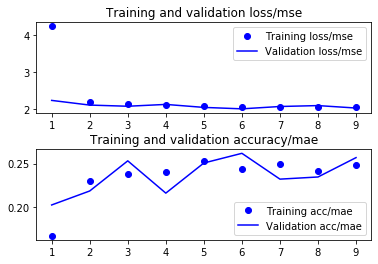

0

In [9]:
# assess the training
net_LCT.plot_train()

We can report loss, accuracy and confusion matrix as any classification task although in this case it may be more informative to inevstigate the difference between true and predicted values instead of classes.

[2.0243351196113073, 0.2529925186883779]


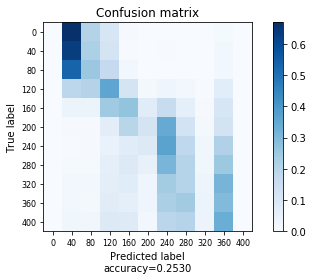

0

In [10]:
# print the testing results [loss, accuracy] and plot confusion matrix
print(net_LCT.test)
net_LCT.plot_cm(gene_sim.classes, text=False)

### 4. deploy the trained network on your genomic data of interest

Finally, we use the trained network to estimate the selection coefficient of our locus of interest.
We can obtain plot of the probability distrbution is more 
can be easily obtained by, for instance, gathering MCMC samples followed by a histogram. MCMC samples can be used to obtain Bayes Factors and HPDI. 
(However, it is not guaranteed that this approach is better than using a regression as final layer. More tests need to be conducted.)

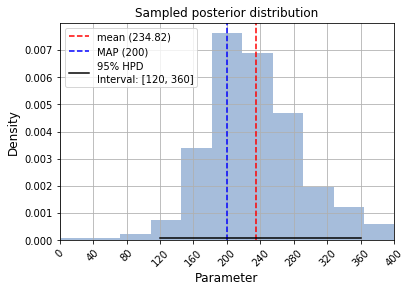

In [15]:
values = plot_scores(model, gene_LCT, classes=gene_sim.classes)

In output this function returns the following values: MAP, MLE, HPD, BF.

In [16]:
print(values)

(200, 234.82440088357419, array([120, 360], dtype=int32), 343.97346904909807)
